# Segregate text reviews into different topics

In this notebook, I'm going to show how we can segregate the text reviews into different topics. 

Why do we need to do that?

Many a times you happen to have large chunk of text reviews and it is inefficient to read them all. If we can cluster them into similar ones and know what each of the cluster talks about, then our life becomes a lot easier. 

Example: 
For a consumer product company who sells 1000s of cosmetic products. If for each of the product, we can ascertain that what are people saying about it's odour , ease of use, ingredients, etc. Also, for each of these topics (for simplicity you can call these clusters or factors too)

That means, there are plenty of advantages of using such a methodology: 

- We can know what are the different reviews trying to say. 
- We can determine for each of the factors, what is the proportion of the reviews that are positive and negative, respectively. 
- We can find out the action areas for different sku's by pointing towards particular topic which has gathered significant negative reviews. 


Let's get started:  

We will be using some pretrained models from Spacy library.


spaCy features new neural models for tagging, parsing and entity recognition. The models have been designed and implemented from scratch specifically for spaCy, to give you an unmatched balance of speed, size and accuracy.



In [69]:

import spacy
from spacy.lang.en import English
parser = English() # Getting the english language parser: 


Defining a function which will tokenize the text data. 

Just for recap, tokenization is a way to split text into tokens. These tokens could be paragraphs, sentences, or individual words. 

In [70]:

def tokenize(text):
    lda_tokens = []
    tokens = parser(text) # Using the english language parser from spacy for tokenization
    for token in tokens:
        if token.orth_.isspace(): #for spaces
            continue
        elif token.like_url: # for urls 
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'): 
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_) # making it lowercase 
    return lda_tokens

In [71]:
#lets use this on on sample text. 

text1 = "Hello World, this is Rajat. @PythonEnthusiast. Visit me at https://github.com/rajatjatana"
tokenize(text1)



['hello',
 'world',
 ',',
 'this',
 'is',
 'rajat',
 '.',
 'SCREEN_NAME',
 '.',
 'visit',
 'me',
 'at',
 'URL']

The above tokenizer converts everything into lowercase. Tags urls as 'URL'. 

Now it is the time to import the nltk library (for wordnet).  

WordNet is a lexical database for the English language, which was created by Princeton, and is part of the NLTK corpus.

It can be used to derive the meaning of words, synonyms, antonyms, etc. 

You can use WordNet alongside the NLTK module to find the meanings of words, synonyms, antonyms, and more.

See the [official Documentation.](http://www.nltk.org/howto/wordnet.html)


In [72]:
import nltk
nltk.download('wordnet')

from nltk.corpus import wordnet as wn

[nltk_data] Downloading package wordnet to C:\Users\HFCA-
[nltk_data]     Rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now, we will use another feature from word net to find the base form of the verbs. 


**Lemmatization**, unlike Stemming, reduces the inflected words properly ensuring that the root word belongs to the language. In Lemmatization root word is called Lemma. A lemma (plural lemmas or lemmata) is the canonical form, dictionary form, or citation form of a set of words.

In [73]:
def lemmatzation1(word):
    """
    Use morphy from WordNet to find the base form of verbs.
    """
    lemma = nltk.corpus.wordnet.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

Let's understand that. 

For example, we have a word "Denied". Let's see its base form. 

In [74]:
nltk.corpus.wordnet.morphy("denied")

'deny'

In [75]:
from nltk.stem.wordnet import WordNetLemmatizer
def lemmatzation2(word):
    return WordNetLemmatizer().lemmatize(word)

In [76]:
# See the examples for above 

print(lemmatzation2("playing") , lemmatzation2("plays")) 

playing play


In [ ]:
# Get the data: 

import pandas as pd 
data = pd.read_csv('Data/text_reviews.csv' , encoding='cp1252')

In [99]:
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import matplotlib.pyplot as plt
%matplotlib inline

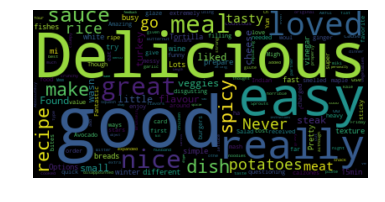

In [100]:
text = str(data.iloc[:,0])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Stopwords: 

From nltk, download the standard stopwords. Then, we will add our own stop words to it. 

In [102]:
nltk.download('stopwords')
en_stop = set(nltk.corpus.stopwords.words('english'))



set2 = set(["recipe"
,"would"
,"better"
,"really"
,"enough"
,"need"
,"delicious"
,"taste"
,"chef"
,"like"
,"great"
,"favourite"
,"good"
,"nice",
"never"])


en_stop = en_stop.union(set2)


[nltk_data] Downloading package stopwords to C:\Users\HFCA-
[nltk_data]     Rajat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


It's the time to prepare the text for the lda.

- Step 1: tokenize the data  
- Step 2: Have only the words which have length >4   
- Step 3: Lemmatize to have the words in a standard form.  

Let's combine the functions prepared above.

In [105]:
def prepare_text_for_lda(text):
    tokens = tokenize(text)
    tokens = [token for token in tokens if len(token) > 4]
    tokens = [token for token in tokens if token not in en_stop]
    tokens = [lemmatzation1(token) for token in tokens]
    return tokens

In [106]:
text_data = []


In [107]:
tokens = prepare_text_for_lda(line)

In [108]:

for i in data.iloc[:,0]: 
    tokens = prepare_text_for_lda(i)
    text_data.append(tokens)

### Genism for topic modelling:

Gensim is billed as a Natural Language Processing package that does ‘Topic Modeling for Humans’. 

It is a great package for processing texts, working with word vector models (such as Word2Vec, FastText etc) and for building topic models.


Two terms, before we proceed: 

**Dictionary**

In order to work on text documents, Gensim requires the words (or tokens) be converted to unique ids. In order to achieve that, Gensim lets you create a Dictionary object that maps each word to a unique id.
create a `Dictionary`? By converting your text/sentences to a [list of words] and pass it to the corpora.Dictionary() object.

**Bag of words (bow)**


The next important object you need to familiarize with in order to work in gensim is the Corpus (a Bag of Words).That is, it is a corpus object that contains the word id and its frequency in each document. You can think of it as gensim’s equivalent of a Document-Term matrix.

In [109]:


from gensim import corpora
dictionary = corpora.Dictionary(text_data)
corpus = [dictionary.doc2bow(text) for text in text_data]


In [111]:
import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')



Time to use LDA from genism. 

In [112]:
import gensim
NUM_TOPICS = 10
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('topic.gensim') # Here we are saving the model. 
topics = ldamodel.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.126*"potato" + 0.041*"sweet" + 0.034*"cook" + 0.027*"bean"')
(1, '0.164*"tasty" + 0.119*"love" + 0.083*"add" + 0.052*"cheese"')
(2, '0.132*"salad" + 0.043*"dressing" + 0.037*"family" + 0.035*"quick"')
(3, '0.162*"sauce" + 0.050*"need" + 0.042*"veggie" + 0.042*"noodle"')
(4, '0.100*"little" + 0.079*"bland" + 0.054*"flavor" + 0.048*"carrot"')
(5, '0.095*"portion" + 0.078*"small" + 0.036*"taste" + 0.027*"dinner"')
(6, '0.096*"spice" + 0.059*"miss" + 0.045*"ingredient" + 0.041*"pepper"')
(7, '0.155*"chicken" + 0.060*"amaze" + 0.051*"spicy" + 0.031*"biscuit"')
(8, '0.071*"fresh" + 0.059*"pasta" + 0.041*"excellent" + 0.038*"like"')
(9, '0.129*"flavour" + 0.060*"enjoy" + 0.045*"yummy" + 0.036*"plate"')


In [123]:
#len(ldamodel.get_topics())

ldamodel.get_document_topics

<bound method LdaModel.get_document_topics of <gensim.models.ldamodel.LdaModel object at 0x000002195CEC8CF8>>

In [113]:
dir(ldamodel)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__ignoreds',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__numpys',
 '__recursive_saveloads',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__scipys',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_apply',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'alpha',
 'bound',
 'callbacks',
 'chunksize',
 'clear',
 'decay',
 'diff',
 'dispatcher',
 'distributed',
 'do_estep',
 'do_mstep',
 'dtype',
 'eta',
 'eval_every',
 'expElogbeta',
 'gamma_threshold',
 'get_document_topics',
 'get_term_topics',
 'get_topic_terms',
 'get_topics',
 'id2word',
 'inference',
 'init_dir_prior',
 'iterations',
 'load',
 'log_perplexity',
 'minimum_phi_value',
 'minimum_probability',
 'num_terms',
 'num_topics'

In [126]:
from itertools import chain
lda_corpus = ldamodel[corpus]



scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))
threshold = sum(scores)/len(scores)


In [127]:
print(threshold)

0.10390587671093492


In [137]:
cluster1 = [j for i,j in zip(lda_corpus,data.iloc[:,0]) if i[0][1] > threshold]
cluster2 = [j for i,j in zip(lda_corpus,data.iloc[:,0]) if i[1][1] > threshold]
cluster3 = [j for i,j in zip(lda_corpus,data.iloc[:,0]) if i[2][1] > threshold]


IndexError: list index out of range

In [136]:
list(data.iloc[:,0])

['very tasty and easy to make on a busy winter night. hit the spot!',
 'good and simple',
 'Options other than meat + breads. No veggies gets old quick.',
 'Delicious dish and easy to prepare. Tortilla strips seemed unnecessary and didn’t really compliment the dish. A quick “Johnny cake” style biscuit or roti would have been better.',
 'would like to try different fishes',
 'Very tasty. Lots of flavour, and great textures. Would order this again for sure!',
 'Pretty good, nice for a fast 15min meal',
 'It was good, but the white wine vinegar was missing and the potatoes took FOREVER to cook.',
 'extremely spicy',
 'The first few bites were really great, but then the sweetness from the tomatoes took over. I dont know what could be added to make it less sweet... but overall it was a really nice dish.',
 'questioning value for the cost?',
 'Amazing!',
 'Though I enjoy the calzones, this filling would have been very bland. I opted to add more of my own vegetables to increase flavour.',
 'W